<a href="https://colab.research.google.com/github/ArsanyLowise/Identifing-the-dependency-of-the-data/blob/main/Iidentifing%20the%20dependency%20of%20the%20data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset

# Set random seed
np.random.seed(42)
torch.manual_seed(42)

# Generate random inputs
num_samples = 1000
x1 = np.random.uniform(-5, 5, num_samples)
x2 = np.random.uniform(-5, 5, num_samples)
x3 = np.random.uniform(-5, 5, num_samples)

# Define equation with sequential dependency
y = 2 * (x1[:-2]**2) + 0.5 * (x2[1:-1]**3) - 3 * np.sin(x3[2:]) + np.random.normal(0, 5, num_samples-2)

# Stack into dataset (creating sequence inputs)
X_seq = np.column_stack((x1[:-2], x2[1:-1], x3[2:]))  # Input as sequences
Y_seq = y.reshape(-1, 1)  # Target values

# Convert to PyTorch tensors
X_tensor = torch.tensor(X_seq, dtype=torch.float32)
Y_tensor = torch.tensor(Y_seq, dtype=torch.float32)

# Create DataLoader
dataset = TensorDataset(X_tensor, Y_tensor)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

print("Dataset Created with Sequential Inputs!")


Dataset Created with Sequential Inputs!


In [ ]:
import torch
import torch.nn as nn

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

        # Fully connected layer
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Initialize hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))

        # Take the last time step output
        out = self.fc(out[:, -1, :])
        return out


In [ ]:
import torch.nn as nn

class LSTMRegression(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMRegression, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        lstm_out, _ = self.lstm(x.unsqueeze(1))  # Add batch dimension
        return self.fc(lstm_out[:, -1, :])  # Take last output

# Model parameters
input_size = 3  # x1, x2, x3
hidden_size = 64
num_layers = 2
output_size = 1

# Initialize model
model = LSTMRegression(input_size, hidden_size, num_layers, output_size)
print(model)


LSTMRegression(
  (lstm): LSTM(3, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)


In [ ]:
import torch.optim as optim

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 500
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader):.4f}")

# Save model
torch.save(model, "lstm_model.pth")
print("Training Completed and Model Saved!")


Epoch [1/500], Loss: 22.8681
Epoch [2/500], Loss: 22.2713
Epoch [3/500], Loss: 22.5497
Epoch [4/500], Loss: 22.9219
Epoch [5/500], Loss: 22.4166
Epoch [6/500], Loss: 22.9704
Epoch [7/500], Loss: 22.4314
Epoch [8/500], Loss: 22.4803
Epoch [9/500], Loss: 22.7405
Epoch [10/500], Loss: 22.7817
Epoch [11/500], Loss: 23.3165
Epoch [12/500], Loss: 23.8805
Epoch [13/500], Loss: 22.4231
Epoch [14/500], Loss: 22.1201
Epoch [15/500], Loss: 22.3943
Epoch [16/500], Loss: 22.2778
Epoch [17/500], Loss: 21.9102
Epoch [18/500], Loss: 22.0884
Epoch [19/500], Loss: 22.8823
Epoch [20/500], Loss: 22.7288
Epoch [21/500], Loss: 21.5610
Epoch [22/500], Loss: 22.2399
Epoch [23/500], Loss: 22.3749
Epoch [24/500], Loss: 21.8216
Epoch [25/500], Loss: 22.3837
Epoch [26/500], Loss: 22.0964
Epoch [27/500], Loss: 22.0151
Epoch [28/500], Loss: 22.1948
Epoch [29/500], Loss: 22.5789
Epoch [30/500], Loss: 22.9993
Epoch [31/500], Loss: 21.5556
Epoch [32/500], Loss: 22.2636
Epoch [33/500], Loss: 22.3514
Epoch [34/500], Los

In [ ]:
# Load trained model
model = torch.load("lstm_model.pth")
model.eval()

# Compute gradient w.r.t. inputs
X_tensor.requires_grad = True
output = model(X_tensor)
output.mean().backward()

print(f"Gradient w.r.t. x1: {X_tensor.grad[:, 0].mean().item():.4f}")
print(f"Gradient w.r.t. x2: {X_tensor.grad[:, 1].mean().item():.4f}")
print(f"Gradient w.r.t. x3: {X_tensor.grad[:, 2].mean().item():.4f}")


Gradient w.r.t. x1: -0.0005
Gradient w.r.t. x2: 0.0124
Gradient w.r.t. x3: 0.0008


<ipython-input-9-b73bbc3a9733>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("lstm_model.pth")


In [ ]:
import pandas as pd

# Convert tensors to numpy
X_np = X_tensor.detach().numpy()
Y_np = Y_tensor.detach().numpy()

# Compute correlation
df = pd.DataFrame(X_np, columns=["x1", "x2", "x3"])
df["y"] = Y_np
correlation_matrix = df.corr()

print("Feature Correlation with Output:")
print(correlation_matrix["y"])


Feature Correlation with Output:
x1   -0.054739
x2    0.777964
x3    0.017342
y     1.000000
Name: y, dtype: float64


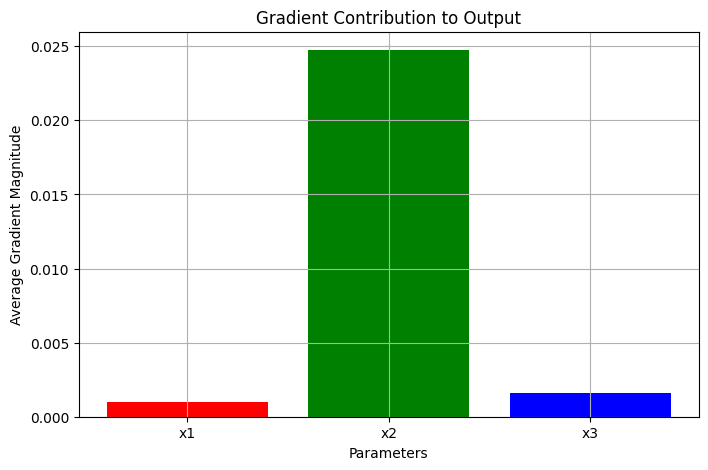

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Compute gradients
X_tensor.requires_grad = True
output = model(X_tensor)
output.mean().backward()

# Average gradients
grad_means = X_tensor.grad.mean(dim=0).detach().numpy()

# Plot gradient contributions
plt.figure(figsize=(8, 5))
plt.bar(["x1", "x2", "x3"], np.abs(grad_means), color=["red", "green", "blue"])
plt.title("Gradient Contribution to Output")
plt.ylabel("Average Gradient Magnitude")
plt.xlabel("Parameters")
plt.grid(True)
plt.show()


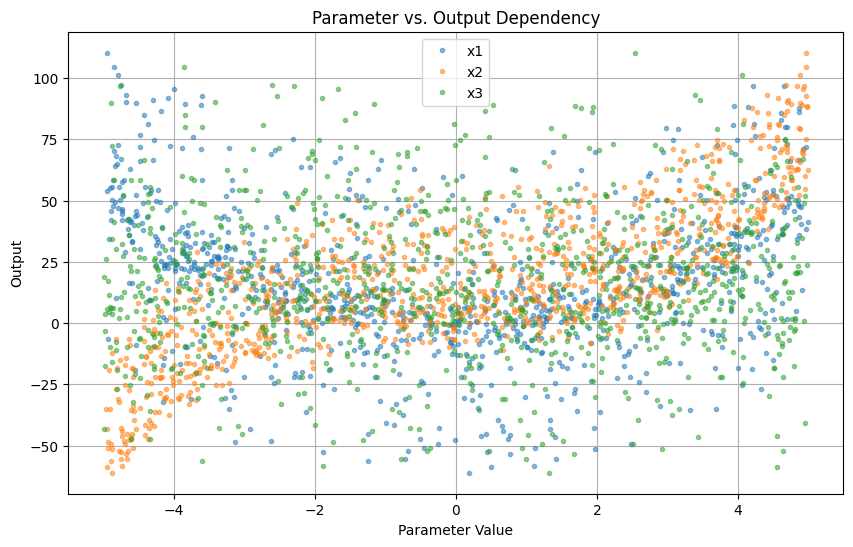

In [ ]:
plt.figure(figsize=(10, 6))

for i, param in enumerate(["x1", "x2", "x3"]):
    plt.plot(X_tensor[:, i].detach().numpy(), Y_tensor.detach().numpy(), '.', label=param, alpha=0.5)

plt.xlabel("Parameter Value")
plt.ylabel("Output")
plt.title("Parameter vs. Output Dependency")
plt.legend()
plt.grid(True)
plt.show()
